In [1]:
#select least depth in each variant of threshold case then prepare copies of best among them

In [2]:
from qiskit_aer import AerSimulator
aer_sim = AerSimulator()
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.transpiler import InstructionProperties
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler import PassManager
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import SamplerV2
from qiskit_ibm_runtime.fake_provider import FakeGuadalupe
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
service = QiskitRuntimeService()

# Get a fake backend from the fake provider
backend = FakeGuadalupe()


def get_ghz_circ_static(num_qubit):
    if num_qubit%2==1:                                                     #odd no of qubits
        qr=QuantumRegister(num_qubit)
        cr2=ClassicalRegister(num_qubit,name="cr2")                     
        qc=QuantumCircuit(qr,cr2)
        mid_qubit_index=int((num_qubit-1)/2)
        qc.h(mid_qubit_index)
        for i in range(mid_qubit_index,num_qubit-1):
            qc.cx(i,i+1)
            qc.cx(num_qubit-i-1,num_qubit-i-2)
        

    else:                                                                    #even no of qubits
        qr=QuantumRegister(num_qubit)
        cr2=ClassicalRegister(num_qubit,name="cr2")                     
        qc=QuantumCircuit(qr,cr2)
        mid_qubit_index=int((num_qubit-2)/2)
        qc.h(mid_qubit_index)
        for i in range(mid_qubit_index,num_qubit-2):
            qc.cx(i,i+1)
            qc.cx(num_qubit-1-i-1,num_qubit-i-3)
        qc.cx(num_qubit-2,num_qubit-1)
    for i in range(num_qubit):
        qc.measure(qr[i],cr2[i])
    return qc

In [3]:
qc=get_ghz_circ_static(16)

In [4]:

# real trnaspilation and ideal transpilation
pm_r = generate_preset_pass_manager(backend=backend, optimization_level=3)
pm_1_r = generate_preset_pass_manager(backend=backend, optimization_level=3, init_method="qubit_reuse_1")
pm_2_r = generate_preset_pass_manager(backend=backend, optimization_level=3, init_method="qubit_reuse_2")
pm_3_r = generate_preset_pass_manager(backend=backend, optimization_level=3, init_method="qubit_reuse_3")
pm_4_r = generate_preset_pass_manager(backend=backend, optimization_level=3, init_method="qubit_reuse_4")
pm_no_threshold_r = generate_preset_pass_manager(backend=backend, optimization_level=3, init_method="qubit_reuse")

pm_i = generate_preset_pass_manager(backend=aer_sim, optimization_level=3)
pm_1_i = generate_preset_pass_manager(backend=aer_sim, optimization_level=3, init_method="qubit_reuse_1")
pm_2_i = generate_preset_pass_manager(backend=aer_sim, optimization_level=3, init_method="qubit_reuse_2")
pm_3_i = generate_preset_pass_manager(backend=aer_sim, optimization_level=3, init_method="qubit_reuse_3")
pm_4_i = generate_preset_pass_manager(backend=aer_sim, optimization_level=3, init_method="qubit_reuse_4")
pm_no_threshold_i = generate_preset_pass_manager(backend=aer_sim, optimization_level=3, init_method="qubit_reuse")

qc_transpiled_list_real=[]                  # for 16 qubit variants
qc_transpiled_list_ideal=[]
copies=8

for i in range(copies):
    qc_no_reuse= pm_r.run(qc)
    qc_1=pm_1_r.run(qc)
    qc_2=pm_2_r.run(qc)
    qc_3=pm_3_r.run(qc)
    qc_4=pm_4_r.run(qc)
    qc_no_threshold=pm_no_threshold_r.run(qc)
    
    qc_transpiled_list_real.append(qc_no_reuse)
    qc_transpiled_list_real.append(qc_1)
    qc_transpiled_list_real.append(qc_2)
    qc_transpiled_list_real.append(qc_3)
    qc_transpiled_list_real.append(qc_4)
    qc_transpiled_list_real.append(qc_no_threshold)

    qc_no_reuse_i= pm_i.run(qc)
    qc_1_i=pm_1_i.run(qc)
    qc_2_i=pm_2_i.run(qc)
    qc_3_i=pm_3_i.run(qc)
    qc_4_i=pm_4_i.run(qc)
    qc_no_threshold_i=pm_no_threshold_i.run(qc)

    qc_transpiled_list_ideal.append(qc_no_reuse_i)
    qc_transpiled_list_ideal.append(qc_1_i)
    qc_transpiled_list_ideal.append(qc_2_i)
    qc_transpiled_list_ideal.append(qc_3_i)
    qc_transpiled_list_ideal.append(qc_4_i)
    qc_transpiled_list_ideal.append(qc_no_threshold_i)

    


threshold received in plugin is 1
threshold received in plugin is 1
threshold received in plugin is 1
threshold received in plugin is 1
threshold received in plugin is 1
threshold received in plugin is 1
threshold received in plugin is 1
threshold received in plugin is 1
threshold received in Greedy is 1
classical registers are [ClassicalRegister(16, 'cr2')]
threshold received in Greedy is 1
classical registers are [ClassicalRegister(16, 'cr2')]
threshold received in Greedy is 1
classical registers are [ClassicalRegister(16, 'cr2')]
threshold received in Greedy is 1
classical registers are [ClassicalRegister(16, 'cr2')]
threshold received in Greedy is 1
classical registers are [ClassicalRegister(16, 'cr2')]
threshold received in Greedy is 1
classical registers are [ClassicalRegister(16, 'cr2')]
threshold received in Greedy is 1
classical registers are [ClassicalRegister(16, 'cr2')]
threshold received in Greedy is 1
classical registers are [ClassicalRegister(16, 'cr2')]
threshold receiv

In [5]:
# compare depth from the prepared list and make a new list
#qc_transpiled_list_real was the previous prepared list,m we will make new modified list in which number of copies will remain
#same but it will be least depth list
def compare(a,b):
    if a.depth()>= b.depth():
        return b
    else:
        return a

def least_depth(A):                          # returns the circuit having least depth
    for i in range(len(A)-2):
        A[i+1]=compare(A[i],A[i+1])
    return A[i+1]                   

B=[]
for i in range(6):
    list_of_random_transpiled_circuits=[]
    for j in range(copies):
        list_of_random_transpiled_circuits.append(qc_transpiled_list_real[j*6 +i])
    B.append(least_depth(list_of_random_transpiled_circuits))


qc_transpiled_list_real=[]
for i in range(copies):
    for j in range(len(B)):
        qc_transpiled_list_real.append(B[j])


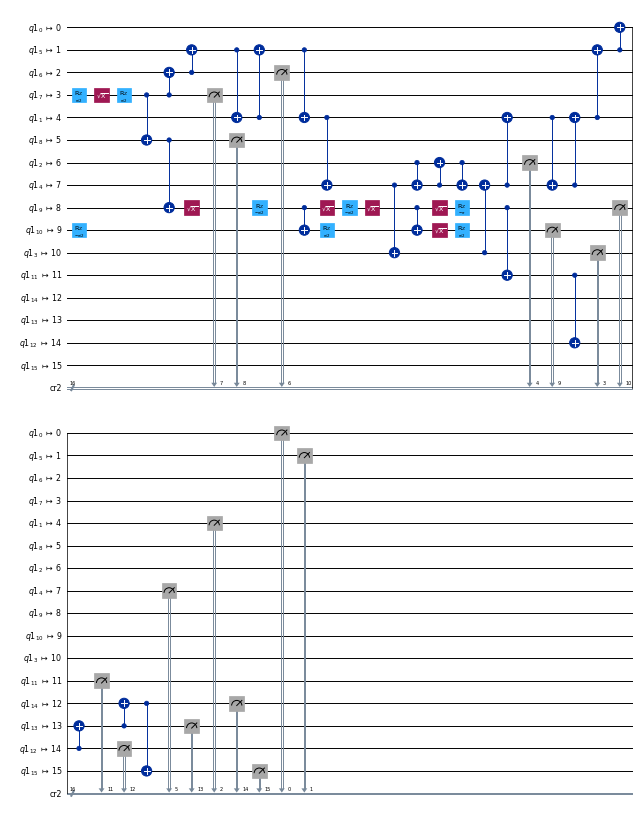

In [6]:
qc_transpiled_list_real[0].draw("mpl",idle_wires=False,scale=0.35)

In [7]:
qc_transpiled_list_real[0].depth()

21

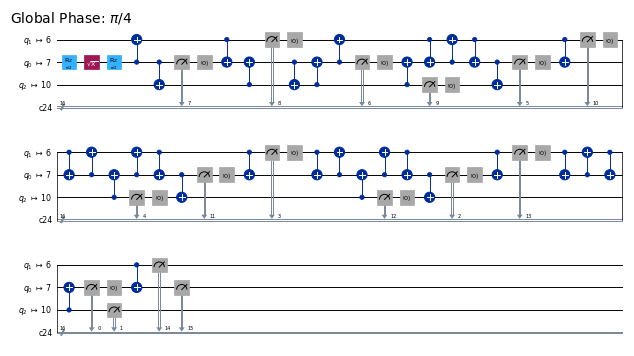

In [8]:
qc_transpiled_list_real[5].draw("mpl",idle_wires=False,scale=0.35)

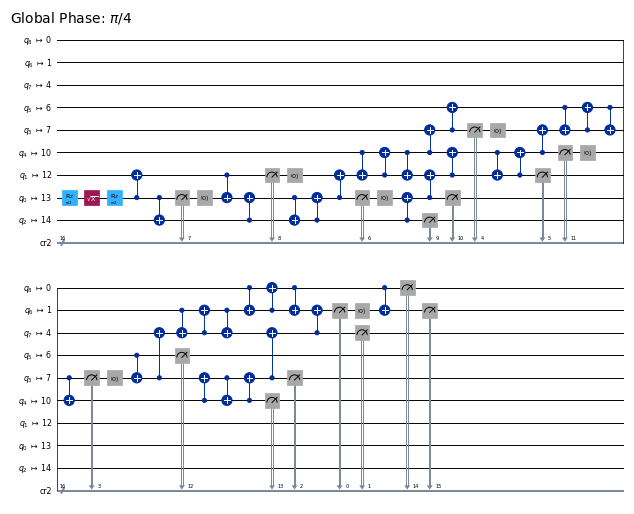

In [9]:
qc_transpiled_list_real[1].draw("mpl",idle_wires=False,scale=0.35)

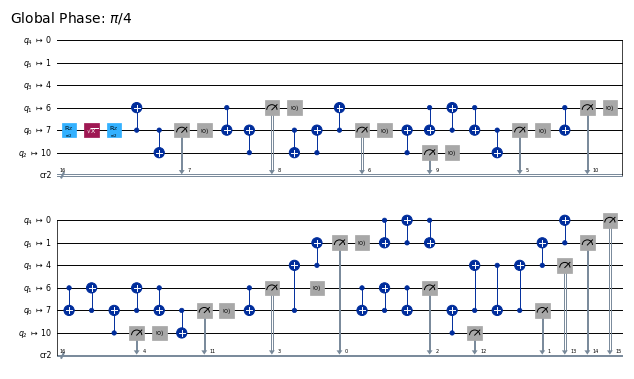

In [10]:
qc_transpiled_list_real[21].draw("mpl",idle_wires=False,scale=0.35)

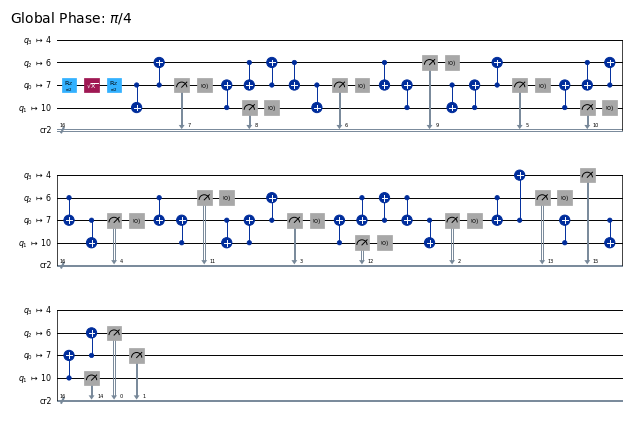

In [11]:
qc_transpiled_list_real[22].draw("mpl",idle_wires=False,scale=0.35)

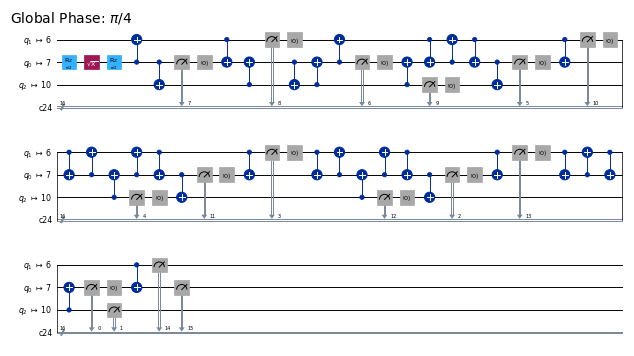

In [12]:
qc_transpiled_list_real[23].draw("mpl",idle_wires=False,scale=0.35)

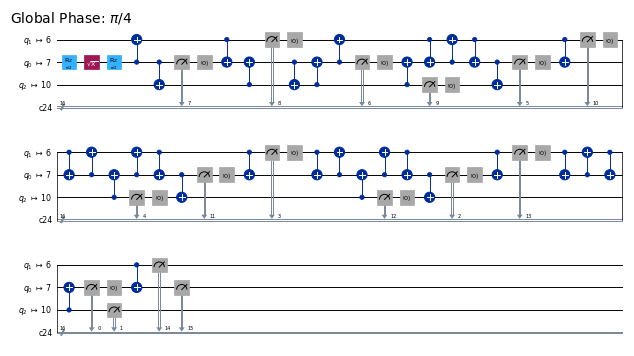

In [13]:
qc_transpiled_list_real[11].draw("mpl",idle_wires=False,scale=0.35)

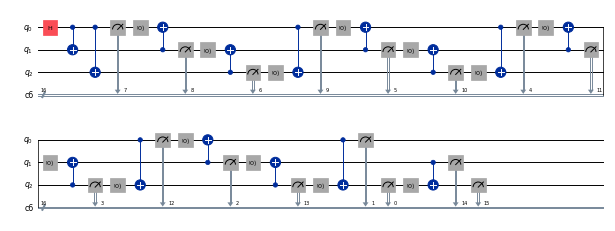

In [14]:
qc_transpiled_list_ideal[11].draw("mpl",idle_wires=False,scale=0.35)

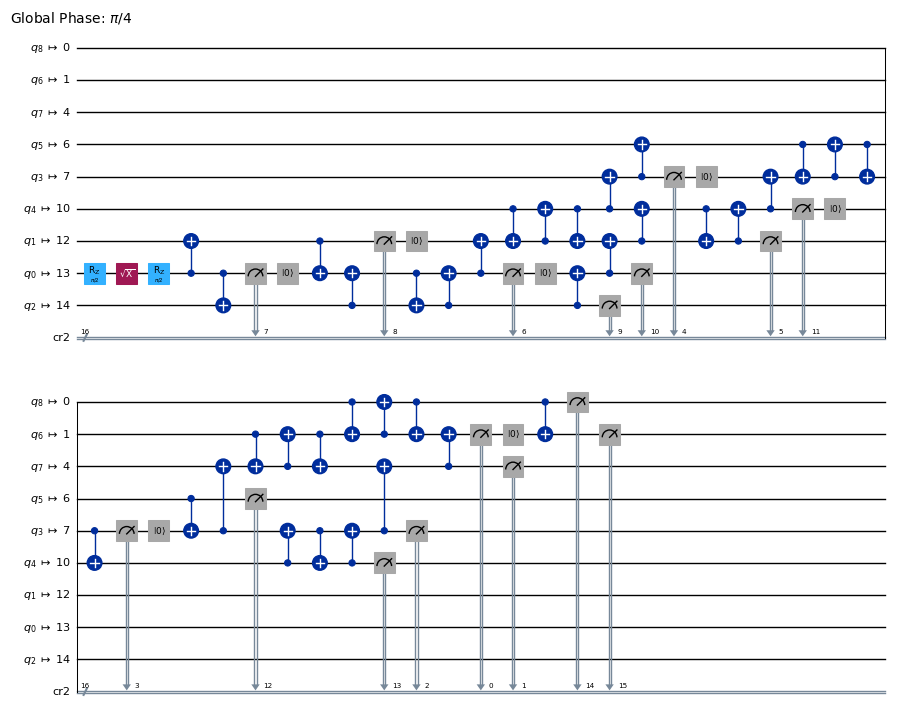

In [40]:
qc_transpiled_list_real[1].draw("mpl",idle_wires=False,scale=0.5)

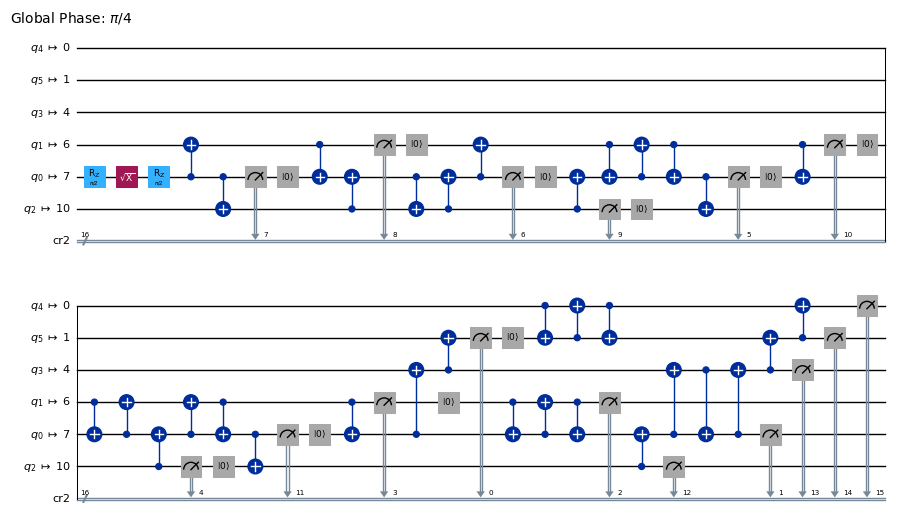

In [39]:
qc_transpiled_list_real[3].draw("mpl",idle_wires=False,scale=0.5)

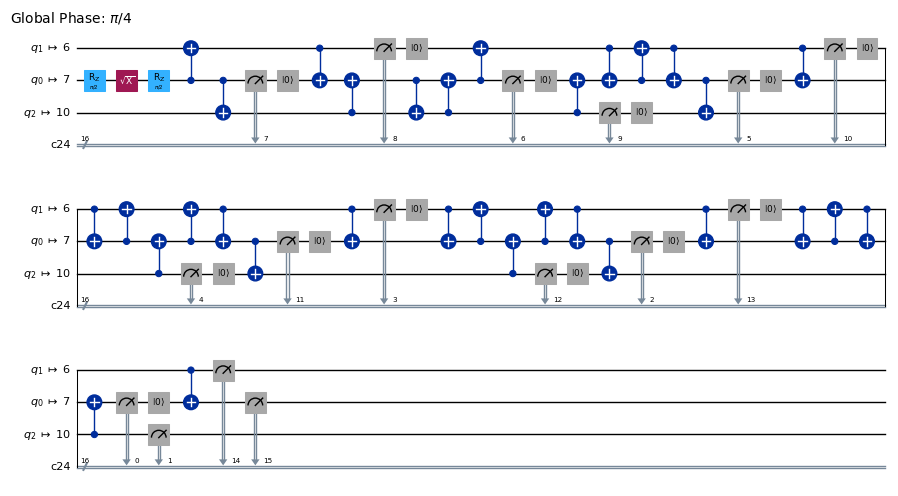

In [38]:
qc_transpiled_list_real[5].draw("mpl",idle_wires=False,scale=0.5)

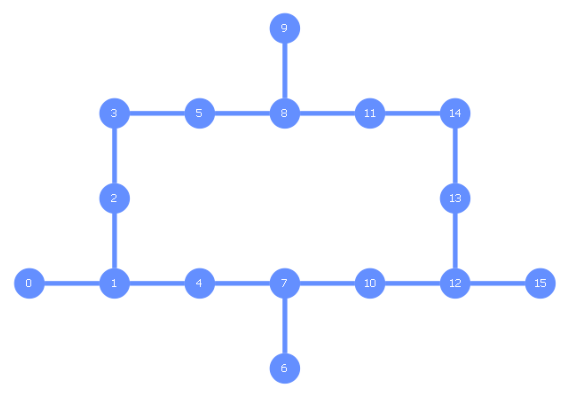

In [18]:
from qiskit.visualization import plot_gate_map
plot_gate_map(backend)

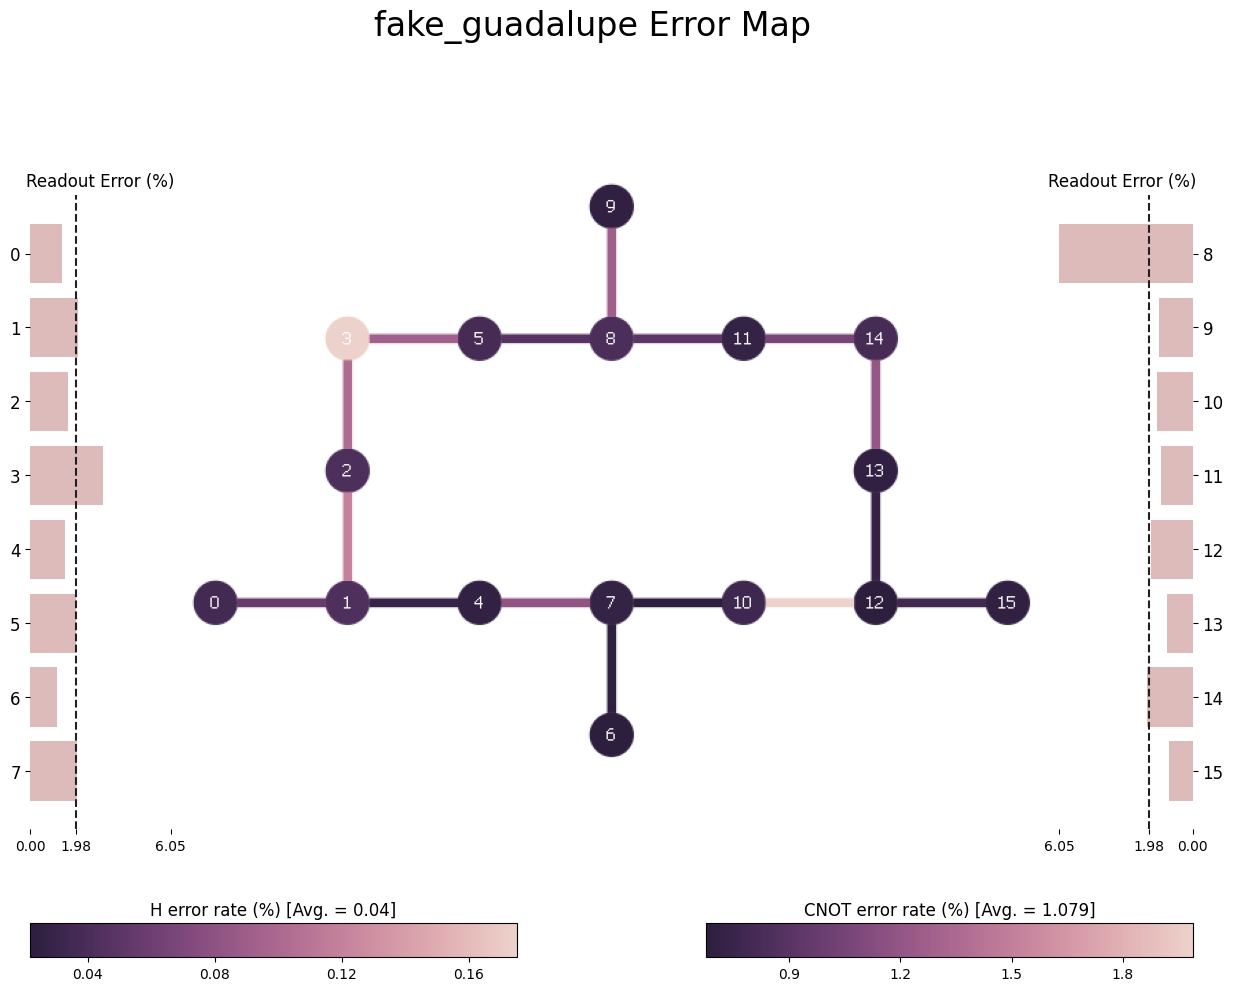

In [19]:
from qiskit.visualization import plot_error_map
plot_error_map(backend)

In [20]:
for i in range(len(qc_transpiled_list_real)):
    print(qc_transpiled_list_real[i].depth())

21
39
41
45
49
54
21
39
41
45
49
54
21
39
41
45
49
54
21
39
41
45
49
54
21
39
41
45
49
54
21
39
41
45
49
54
21
39
41
45
49
54
21
39
41
45
49
54


In [21]:
#ideal simulation
from qiskit_ibm_runtime import SamplerV2 as Sampler
sampler = Sampler(backend=aer_sim)
result_ideal = sampler.run(qc_transpiled_list_ideal).result()
print(result_ideal)
len(result_ideal)

PrimitiveResult([PubResult(data=DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=16>))), PubResult(data=DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=16>))), PubResult(data=DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=16>))), PubResult(data=DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=16>))), PubResult(data=DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=16>))), PubResult(data=DataBin(c2=BitArray(<shape=(), num_shots=1024, num_bits=16>))), PubResult(data=DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=16>))), PubResult(data=DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=16>))), PubResult(data=DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=16>))), PubResult(data=DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=16>))), PubResult(data=DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=16>))), PubResult(data=DataBin(c6=BitArray(<shape=(), num_shots=1024, num_bits=16>))), PubResult(data=DataBin(cr

48

In [22]:
result_ideal[5].data.c2.get_counts()

{'1111111111111111': 513, '0000000000000000': 511}

In [23]:
#fake backend simulation
sampler = Sampler(backend=backend)
result_real = sampler.run(qc_transpiled_list_real).result()
print(result_real)
len(result_real)

PrimitiveResult([PubResult(data=DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=16>))), PubResult(data=DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=16>))), PubResult(data=DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=16>))), PubResult(data=DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=16>))), PubResult(data=DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=16>))), PubResult(data=DataBin(c24=BitArray(<shape=(), num_shots=1024, num_bits=16>))), PubResult(data=DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=16>))), PubResult(data=DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=16>))), PubResult(data=DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=16>))), PubResult(data=DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=16>))), PubResult(data=DataBin(cr2=BitArray(<shape=(), num_shots=1024, num_bits=16>))), PubResult(data=DataBin(c24=BitArray(<shape=(), num_shots=1024, num_bits=16>))), PubResult(data=DataBin(

48

In [24]:
# For getting list of ideal counts (argument required for Fidelity)
counts_list_ideal=[]
k=1 
i=0          # I don't need range of qubits, experiment is for only a certain number of qubit e.g. 16 qubit ghz circuit
for j in range(copies):
    data_static = result_ideal[(6*i*copies)+(6*j)].data                 # no qubit reuse
    data_dynamic_1 = result_ideal[(6*i*copies)+((6*j)+1)].data           # qubit reuse with threshold 1
    data_dynamic_2 = result_ideal[(6*i*copies)+((6*j)+2)].data           # qubit reuse with threshold 2
    data_dynamic_3 = result_ideal[(6*i*copies)+((6*j)+3)].data            # qubit reuse with threshold 3
    data_dynamic_4 = result_ideal[(6*i*copies)+((6*j)+4)].data           # qubit reuse with threshold 4
    data_dynamic_5 = result_ideal[(6*i*copies)+((6*j)+5)].data           # qubit reuse without modification
   # data_dynamic_6 = result_ideal[(7*i*copies)+((7*j)+6)].data           # qubit reuse without modification
    print(result_ideal[5])
    counts_static=data_static.cr2.get_counts()             # normal reuse
    counts_dynamic_1=data_dynamic_1.cr2.get_counts()      # 1
    counts_dynamic_2=data_dynamic_2.cr2.get_counts()      # modified reuse 2
    counts_dynamic_3=data_dynamic_3.cr2.get_counts()      # modified reuse3
    counts_dynamic_4=data_dynamic_4.cr2.get_counts()      # modified reuse4
    #counts_dynamic_5=data_dynamic_5.cr2.get_counts()       
    #counts_dynamic_6=data_dynamic_6.cr2.get_counts()      # modified reuse
    
    # Replacing 'cr2' with the appropriate attribute if needed           # reuse without modification
    dynamic_5_attr_name = f'c{4*k-2}'
    if hasattr(data_dynamic_5, dynamic_5_attr_name):
        counts_dynamic_5 = getattr(data_dynamic_5, dynamic_5_attr_name).get_counts()
    else:
        raise AttributeError(f"{dynamic_5_attr_name} not found in data_dynamic_5")
    
    counts_list_ideal.append(counts_static)             # no reuse
    counts_list_ideal.append(counts_dynamic_1)          # 1
    counts_list_ideal.append(counts_dynamic_2)         #2
    counts_list_ideal.append(counts_dynamic_3)         # 3
    counts_list_ideal.append(counts_dynamic_4)         # reuse 4
    counts_list_ideal.append(counts_dynamic_5)          # reuse without modification
    #counts_list_ideal.append(counts_dynamic_6)
    k=k+1

PubResult(data=DataBin(c2=BitArray(<shape=(), num_shots=1024, num_bits=16>)))
PubResult(data=DataBin(c2=BitArray(<shape=(), num_shots=1024, num_bits=16>)))
PubResult(data=DataBin(c2=BitArray(<shape=(), num_shots=1024, num_bits=16>)))
PubResult(data=DataBin(c2=BitArray(<shape=(), num_shots=1024, num_bits=16>)))
PubResult(data=DataBin(c2=BitArray(<shape=(), num_shots=1024, num_bits=16>)))
PubResult(data=DataBin(c2=BitArray(<shape=(), num_shots=1024, num_bits=16>)))
PubResult(data=DataBin(c2=BitArray(<shape=(), num_shots=1024, num_bits=16>)))
PubResult(data=DataBin(c2=BitArray(<shape=(), num_shots=1024, num_bits=16>)))


In [26]:
# For getting list of noisy simulation counts (argument required for Fidelity)
counts_list_real=[]
k=1
i=0
#for i in range(len(num_qubit_list)):  
for j in range(copies):
    data_static = result_real[(6*i*copies)+(6*j)].data    
    data_dynamic_1 = result_real[(6*i*copies)+((6*j)+1)].data 
    data_dynamic_2 = result_real[(6*i*copies)+((6*j)+2)].data
    data_dynamic_3 = result_real[(6*i*copies)+((6*j)+3)].data
    data_dynamic_4 = result_real[(6*i*copies)+((6*j)+4)].data
    data_dynamic_5 = result_real[(6*i*copies)+((6*j)+5)].data
    #data_dynamic_6 = result_real[(7*i*copies)+((7*j)+6)].data
  
    counts_static=data_static.cr2.get_counts()            # normal reuse
    counts_dynamic_1=data_dynamic_1.cr2.get_counts()     # modified reuse1
    counts_dynamic_2=data_dynamic_2.cr2.get_counts()      # modified reuse2
    counts_dynamic_3=data_dynamic_3.cr2.get_counts()      # modified reuse3
    counts_dynamic_4=data_dynamic_4.cr2.get_counts()      # modified reuse4
    counts_dynamic_5=data_dynamic_5.c24.get_counts()      #
    #counts_dynamic_6=data_dynamic_6.cr2.get_counts()      #
    
    # Replacing 'cr2' with the appropriate attribute if needed      #  qubit reuse no modification
   # dynamic_5_attr_name = f'c{4*k-4}'
   # if hasattr(data_dynamic_5, dynamic_5_attr_name):
     #   counts_dynamic_5 = getattr(data_dynamic_5, dynamic_5_attr_name).get_counts()
   # else:
    #    raise AttributeError(f"{dynamic_5_attr_name} not found in data_dynamic_5")
    
    counts_list_real.append(counts_static)
    counts_list_real.append(counts_dynamic_1)
    counts_list_real.append(counts_dynamic_2)
    counts_list_real.append(counts_dynamic_3)
    counts_list_real.append(counts_dynamic_4)
    counts_list_real.append(counts_dynamic_5)
    #counts_list_real.append(counts_dynamic_6)
    k=k+1

In [27]:
#Calculation of lists of Fidelity mean and std deviation of real hardware simulation in ibm_sherbrooke
import statistics
from qiskit.quantum_info.analysis import hellinger_fidelity
# We will create 4 lists of Fidelities, for storing mean, std deviation of Fidelity, of copies of a circuit for fixed no of logical qubits
 
Fidelity_mean_static_sherbrooke=[]
Fidelity_mean_dynamic_1_sherbrooke=[]
Fidelity_mean_dynamic_2_sherbrooke=[]
Fidelity_mean_dynamic_3_sherbrooke=[]
Fidelity_mean_dynamic_4_sherbrooke=[]
Fidelity_mean_dynamic_5_sherbrooke=[]
Fidelity_mean_dynamic_6_sherbrooke=[]

Fidelity_std_static_sherbrooke=[]
Fidelity_std_dynamic_1_sherbrooke=[]
Fidelity_std_dynamic_2_sherbrooke=[]
Fidelity_std_dynamic_3_sherbrooke=[]
Fidelity_std_dynamic_4_sherbrooke=[]
Fidelity_std_dynamic_5_sherbrooke=[]
Fidelity_std_dynamic_6_sherbrooke=[]

Fidelity_copies_static_sherbrooke=[]
Fidelity_copies_dynamic_1_sherbrooke=[]
Fidelity_copies_dynamic_2_sherbrooke=[]
Fidelity_copies_dynamic_3_sherbrooke=[]
Fidelity_copies_dynamic_4_sherbrooke=[]
Fidelity_copies_dynamic_5_sherbrooke=[]
Fidelity_copies_dynamic_6_sherbrooke=[]

#for i in range(len(num_qubit_list)):
i=0    
for j in range(copies):
    
    Fidelity_static= hellinger_fidelity(counts_list_ideal[(6*i*copies)+(6*j)], counts_list_real[(6*i*copies)+(6*j)])
    Fidelity_dynamic_1=hellinger_fidelity(counts_list_ideal[(6*i*copies)+((6*j)+1)], counts_list_real[(6*i*copies)+((6*j)+1)])
    Fidelity_dynamic_2=hellinger_fidelity(counts_list_ideal[(6*i*copies)+((6*j)+2)], counts_list_real[(6*i*copies)+((6*j)+2)])
    Fidelity_dynamic_3=hellinger_fidelity(counts_list_ideal[(6*i*copies)+((6*j)+3)], counts_list_real[(6*i*copies)+((6*j)+3)])
    Fidelity_dynamic_4=hellinger_fidelity(counts_list_ideal[(6*i*copies)+((6*j)+4)], counts_list_real[(6*i*copies)+((6*j)+4)])
    Fidelity_dynamic_5=hellinger_fidelity(counts_list_ideal[(6*i*copies)+((6*j)+5)], counts_list_real[(6*i*copies)+((6*j)+5)])
    #Fidelity_dynamic_6=hellinger_fidelity(counts_list_ideal[(7*i*copies)+((7*j)+6)], counts_list_real[(7*i*copies)+((7*j)+6)])
    
    Fidelity_copies_static_sherbrooke.append(Fidelity_static)
    Fidelity_copies_dynamic_1_sherbrooke.append(Fidelity_dynamic_1)
    Fidelity_copies_dynamic_2_sherbrooke.append(Fidelity_dynamic_2)
    Fidelity_copies_dynamic_3_sherbrooke.append(Fidelity_dynamic_3)
    Fidelity_copies_dynamic_4_sherbrooke.append(Fidelity_dynamic_4)
    Fidelity_copies_dynamic_5_sherbrooke.append(Fidelity_dynamic_5)
    #Fidelity_copies_dynamic_6_sherbrooke.append(Fidelity_dynamic_6)


Fidelity_mean_static_sherbrooke.append(statistics.mean(Fidelity_copies_static_sherbrooke))
Fidelity_mean_dynamic_1_sherbrooke.append(statistics.mean(Fidelity_copies_dynamic_1_sherbrooke))
Fidelity_mean_dynamic_2_sherbrooke.append(statistics.mean(Fidelity_copies_dynamic_2_sherbrooke))
Fidelity_mean_dynamic_3_sherbrooke.append(statistics.mean(Fidelity_copies_dynamic_3_sherbrooke))
Fidelity_mean_dynamic_4_sherbrooke.append(statistics.mean(Fidelity_copies_dynamic_4_sherbrooke))
Fidelity_mean_dynamic_5_sherbrooke.append(statistics.mean(Fidelity_copies_dynamic_5_sherbrooke))
#Fidelity_mean_dynamic_6_sherbrooke.append(statistics.mean(Fidelity_copies_dynamic_6_sherbrooke))

Fidelity_std_static_sherbrooke.append(statistics.stdev(Fidelity_copies_static_sherbrooke))
Fidelity_std_dynamic_1_sherbrooke.append(statistics.stdev(Fidelity_copies_dynamic_1_sherbrooke))
Fidelity_std_dynamic_2_sherbrooke.append(statistics.stdev(Fidelity_copies_dynamic_2_sherbrooke))
Fidelity_std_dynamic_3_sherbrooke.append(statistics.stdev(Fidelity_copies_dynamic_3_sherbrooke))
Fidelity_std_dynamic_4_sherbrooke.append(statistics.stdev(Fidelity_copies_dynamic_4_sherbrooke))
Fidelity_std_dynamic_5_sherbrooke.append(statistics.stdev(Fidelity_copies_dynamic_5_sherbrooke))
#Fidelity_std_dynamic_6_sherbrooke.append(statistics.stdev(Fidelity_copies_dynamic_6_sherbrooke))

Fidelity_copies_static_sherbrooke.clear()
Fidelity_copies_dynamic_1_sherbrooke.clear()
Fidelity_copies_dynamic_2_sherbrooke.clear()
Fidelity_copies_dynamic_3_sherbrooke.clear()
Fidelity_copies_dynamic_4_sherbrooke.clear()
Fidelity_copies_dynamic_5_sherbrooke.clear()
#Fidelity_copies_dynamic_6_sherbrooke.clear()

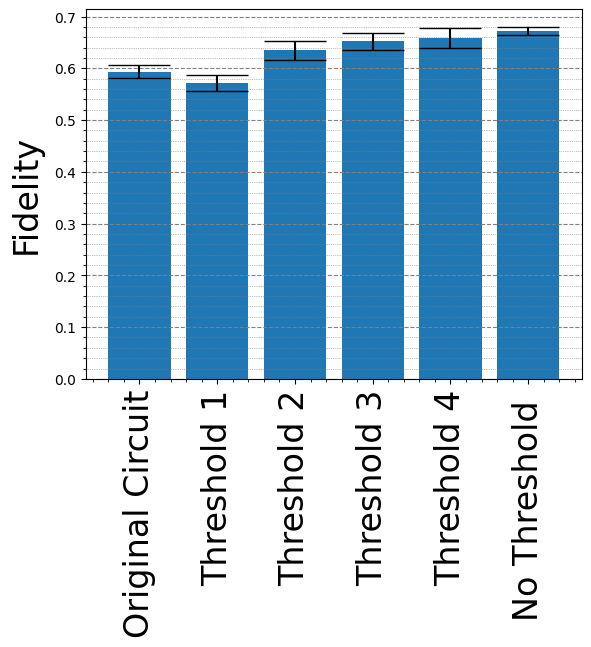

In [28]:
import matplotlib.pyplot as plt

# Sample data
categories = ['Original Circuit', 'Threshold 1', 'Threshold 2', 'Threshold 3', 'Threshold 4', 'No Threshold ']
a=[]
a.append(Fidelity_mean_static_sherbrooke[0])              # no reuse
a.append(Fidelity_mean_dynamic_1_sherbrooke[0])            # reuse 1
a.append(Fidelity_mean_dynamic_2_sherbrooke[0])
a.append(Fidelity_mean_dynamic_3_sherbrooke[0])
a.append(Fidelity_mean_dynamic_4_sherbrooke[0])           # reuse 4
a.append(Fidelity_mean_dynamic_5_sherbrooke[0])          # no threshold

a_e=[]
a_e.append(Fidelity_std_static_sherbrooke[0])
a_e.append(Fidelity_std_dynamic_1_sherbrooke[0])
a_e.append(Fidelity_std_dynamic_2_sherbrooke[0])
a_e.append(Fidelity_std_dynamic_3_sherbrooke[0])
a_e.append(Fidelity_std_dynamic_4_sherbrooke[0])
a_e.append(Fidelity_std_dynamic_5_sherbrooke[0])

values = a
values2=[16,9,6,6,4,3]

depth=[]
for i in range(6):
    depth.append(qc_transpiled_list_real[i].depth())

values3=depth
#plt.bar(categories, values)

bars = plt.bar(categories, values, yerr=a_e, capsize=22)

# Adding labels inside the bars
#for bar, category in zip(bars, categories):
#    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, category, ha='center', va='center', color='white',rotation=90)

#plt.xlabel('Categories')


# Adding labels to the X-axis
plt.xticks(rotation=90,fontsize=24)
#plt.xlabel('Categories')
#plt.xlabel('Variants of 16 Qubit GHZ State Circuit')
plt.ylabel('Fidelity',labelpad=8,fontsize=24)
#plt.title('16 Qubit GHZ state Circuit')
# Add y-axis major and minor grid lines
plt.grid(which='both', axis='y', linestyle='--', linewidth=0.8, color='gray')
plt.grid(which='minor', axis='y', linestyle=':', linewidth=0.5, color='gray')
plt.minorticks_on()
#plt.title('16 Qubit GHZ state Circuit')
plt.savefig('figure_fake_fid.pdf', format='pdf')

plt.show()

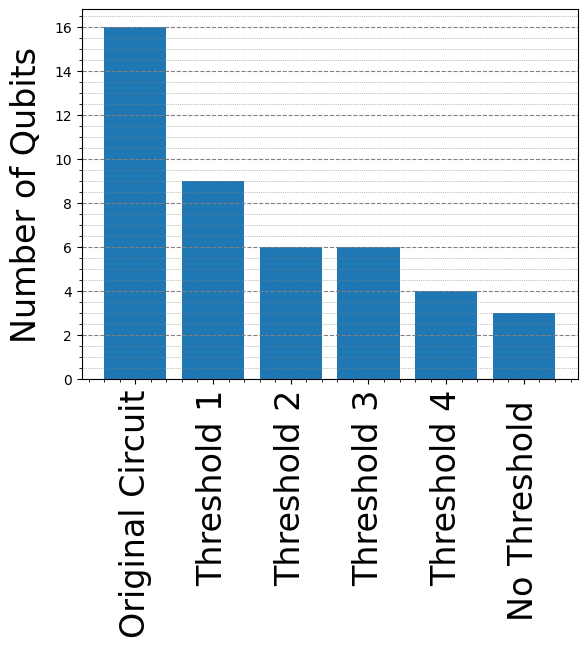

In [29]:
bars = plt.bar(categories, values2)

# Adding labels inside the bars
#for bar, category in zip(bars, categories):
 #   plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, category, ha='center', va='center', color='white',rotation=90)

#plt.xlabel('Categories')


# Adding labels to the X-axis
plt.xticks(rotation=90,fontsize=24)
#plt.xlabel('Categories')
#plt.xlabel('Variants of 16 Qubit GHZ State Circuit')
plt.ylabel('Number of Qubits',labelpad=8,fontsize=24)
# Add y-axis major and minor grid lines
plt.grid(which='both', axis='y', linestyle='--', linewidth=0.8, color='gray')
plt.grid(which='minor', axis='y', linestyle=':', linewidth=0.5, color='gray')
plt.minorticks_on()
#plt.title('16 Qubit GHZ state Circuit')
plt.savefig('figure_fake_qubit_saving.pdf', format='pdf')
#plt.title('16 Qubit GHZ state Circuit')

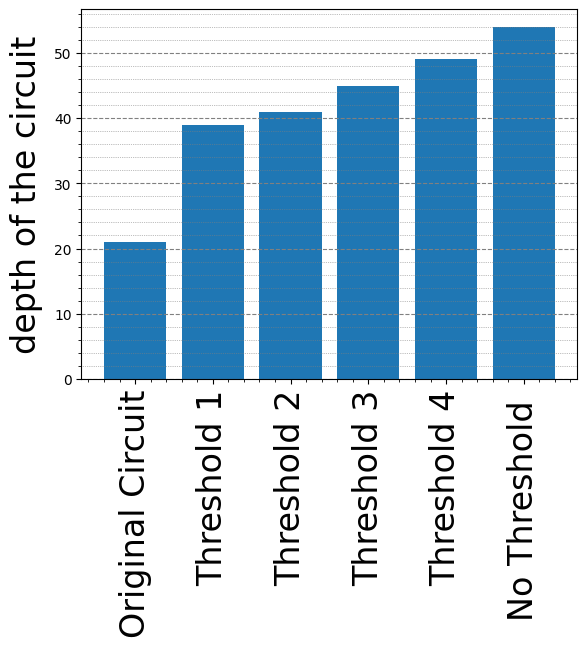

In [30]:

bars = plt.bar(categories, values3)

# Adding labels inside the bars
#for bar, category in zip(bars, categories):
#    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, category, ha='center', va='center', color='white',rotation=90)

#plt.xlabel('Categories')


# Adding labels to the X-axis
plt.xticks(rotation=90,fontsize=24)
#plt.xlabel('Categories')
#plt.xlabel('Variants of 16 Qubit GHZ State Circuit')
plt.ylabel('depth of the circuit',labelpad=8,fontsize=24)
# Add y-axis major and minor grid lines
plt.grid(which='both', axis='y', linestyle='--', linewidth=0.8, color='gray')
plt.grid(which='minor', axis='y', linestyle=':', linewidth=0.5, color='gray')
plt.minorticks_on()
#plt.title('16 Qubit GHZ state Circuit')

In [41]:
a

[0.5936992007573071,
 0.5717429351316439,
 0.6349312320133805,
 0.6518652879238676,
 0.6582690581208447,
 0.6719186011471849]

In [31]:
qc_transpiled_list_real[4].depth()   # depths are 21,39,41,45,49,54

49

In [32]:
qc_transpiled_list_real[5].depth()

54

In [33]:
qc_transpiled_list_real[0].depth()

21

In [34]:
qc_transpiled_list_real[1].depth()

39

In [35]:
qc_transpiled_list_real[2].depth()

41

In [36]:
qc_transpiled_list_real[3].depth()

45

In [37]:
a

[0.5936992007573071,
 0.5717429351316439,
 0.6349312320133805,
 0.6518652879238676,
 0.6582690581208447,
 0.6719186011471849]

In [ ]:
import matplotlib.pyplot as plt

# Sample data
categories = ['Original Circuit', 'Threshold 1', 'Threshold 2', 'Threshold 3', 'Threshold 4', 'No Threshold ']
a=[]
a.append(Fidelity_mean_static_sherbrooke[0])              # no reuse
a.append(Fidelity_mean_dynamic_1_sherbrooke[0])            # reuse 1
a.append(Fidelity_mean_dynamic_2_sherbrooke[0])
a.append(Fidelity_mean_dynamic_3_sherbrooke[0])
a.append(Fidelity_mean_dynamic_4_sherbrooke[0])           # reuse 4
a.append(Fidelity_mean_dynamic_5_sherbrooke[0])          # no threshold

a_e=[]
a_e.append(Fidelity_std_static_sherbrooke[0])
a_e.append(Fidelity_std_dynamic_1_sherbrooke[0])
a_e.append(Fidelity_std_dynamic_2_sherbrooke[0])
a_e.append(Fidelity_std_dynamic_3_sherbrooke[0])
a_e.append(Fidelity_std_dynamic_4_sherbrooke[0])
a_e.append(Fidelity_std_dynamic_5_sherbrooke[0])

values = a
values2=[16,9,6,6,4,3]

depth=[]
for i in range(6):
    depth.append(qc_transpiled_list_real[i].depth())

values3=depth
#plt.bar(categories, values)

bars = plt.bar(categories, values, yerr=a_e, capsize=22)

# Adding labels inside the bars
#for bar, category in zip(bars, categories):
#    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, category, ha='center', va='center', color='white',rotation=90)

#plt.xlabel('Categories')


# Adding labels to the X-axis
plt.xticks(rotation=90,fontsize=24)
#plt.xlabel('Categories')
#plt.xlabel('Variants of 16 Qubit GHZ State Circuit')
plt.ylabel('Fidelity',labelpad=8,fontsize=24)
#plt.title('16 Qubit GHZ state Circuit')
# Add y-axis major and minor grid lines
plt.grid(which='both', axis='y', linestyle='--', linewidth=0.8, color='gray')
plt.grid(which='minor', axis='y', linestyle=':', linewidth=0.5, color='gray')
plt.minorticks_on()
#plt.title('16 Qubit GHZ state Circuit')
plt.savefig('figure_fake_fid.pdf', format='pdf')

plt.show()

In [ ]:
a

In [ ]:
print(depth)

In [ ]:
bars = plt.bar(categories, values2)

# Adding labels inside the bars
#for bar, category in zip(bars, categories):
 #   plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, category, ha='center', va='center', color='white',rotation=90)

#plt.xlabel('Categories')


# Adding labels to the X-axis
plt.xticks(rotation=90,fontsize=24)
#plt.xlabel('Categories')
#plt.xlabel('Variants of 16 Qubit GHZ State Circuit')
plt.ylabel('Number of Qubits',labelpad=8,fontsize=24)
# Add y-axis major and minor grid lines
plt.grid(which='both', axis='y', linestyle='--', linewidth=0.8, color='gray')
plt.grid(which='minor', axis='y', linestyle=':', linewidth=0.5, color='gray')
plt.minorticks_on()
#plt.title('16 Qubit GHZ state Circuit')
plt.savefig('figure_fake_qubit_saving.pdf', format='pdf')
#plt.title('16 Qubit GHZ state Circuit')

In [ ]:
bars = plt.bar(categories, values3)

# Adding labels inside the bars
for bar, category in zip(bars, categories):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, category, ha='center', va='center', color='white',rotation=90)

#plt.xlabel('Categories')


# Adding labels to the X-axis
plt.xticks(rotation=90)
#plt.xlabel('Categories')
#plt.xlabel('Variants of 16 Qubit GHZ State Circuit')
plt.ylabel('depth of the circuit')
plt.title('16 Qubit GHZ state Circuit')

In [ ]:

from qiskit.visualization import plot_circuit_layout

plot_circuit_layout(qc_transpiled_list_real[0], backend)


In [ ]:
plot_circuit_layout(qc_transpiled_list_real[1], backend)

In [ ]:
plot_circuit_layout(qc_transpiled_list_real[2], backend)

In [ ]:
plot_circuit_layout(qc_transpiled_list_real[3], backend)

In [ ]:
plot_circuit_layout(qc_transpiled_list_real[4], backend)

In [ ]:
plot_circuit_layout(qc_transpiled_list_real[5], backend)

In [ ]:
plot_circuit_layout(qc_transpiled_list_real[7], backend)